# Are We There Yet?

You are visiting your friend and it will require
* A 5 minute walk to the ‘L’ station
* Waiting for the train, which arrives every 20 minutes
* Traveling 30 minutes by ‘L’
* Catching a taxi at the ‘L’ destination
  * There is a 20% chance that the car is waiting for you
  * Otherwise the average wait time is 10 minutes
* A 12 minute taxi ride 

_How long should you plan for the trip to take?_

#### Some LaTeX macros (hidden in math mode, will not render correctly in VS Code)
$
\newcommand{\vh}{\boldsymbol{h}}
\newcommand{\vt}{\boldsymbol{t}}
\newcommand{\vx}{\boldsymbol{x}}
\newcommand{\vX}{\boldsymbol{X}}
\newcommand{\cf}{\mathcal{F}}
\newcommand{\cu}{\mathcal{U}}
\newcommand{\dif}{\mathrm{d}}
\newcommand{\Ex}{\mathbb{E}}
\DeclareMathOperator{\disc}{disc}
\DeclareMathOperator{\Prob}{\mathbb{P}}
% \norm{x}{2} -> \left\lVert x \right\rVert_{2}
\newcommand{\norm}[2]{{\left \lVert #1 \right \rVert}_{#2}}
$

#### Run this notebook in Juypter with the `conda qmcpy` environment or [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/QMCSoftware/MATH565Fall2025/blob/main/notebooks/AreWeThereYet.ipynb?flush_cache=true)

In [6]:
if "google.colab" in str(get_ipython()):
    print("⚡Note: Setup here can take a few minutes.")
    !apt-get -y install cm-super dvipng texlive-latex-extra texlive-latex-recommended
    !pip install git+https://github.com/QMCSoftware/QMCSoftware.git@develop
    !git clone https://github.com/QMCSoftware/MATH565Fall2025.git
    %cd MATH565Fall2025/notebooks
    print("\n✅ Colab setup complete.")
    print("   For faster performance, please install the qmcpy environment locally.")

## Mathematical set-up
\begin{aligned}
T & = \text{travel time} = 5 + W_1 + 30 + W_2 + 12 = 47 + W_1 + W_2 \\
W_1 & = \text{waiting time for 'L' train} \sim \mathcal{U}[0,20] \\
W_2 & = \text{waiting time for taxi}, \quad 
\Prob(W_2 \le w) = \begin{cases} 0, & w < 0 \\ 0.2+ 0.04 \exp(-w/20), & w \ge 0 \end{cases}
\end{aligned}

We assume that $W_1$ and $W_2$ are independent

We will now perform Monte Carlo simulation


## Monte Carlo estimation of the average waiting time

### Import needed packages and initialize some parameters

In [7]:
import matplotlib.pyplot as plt
import math, time, timeit, sys
import numpy as np
import scipy as sp
from scipy import stats
import qmcpy as qp
import sympy as sy
import mc_class as init
init.init()                 # apply rcParams + numpy error policy
colors = init.get_py_colors()

### Set up random variables $W_1$ and $W_2$

In [8]:
# --- Parameters
walk_time = 5  #time to walk to the 'L'
on_L_time = 30  #time on the 'L'
taxi_time = 12  #time in the taxi
T0 = walk_time + on_L_time + taxi_time # fixed time
wait_L_time = 20  #max time until next 'L' train
taxi_now = 0.2  #probability of taxi now
taxi_wait_avg = 10  #average time to wait for a taxi if it is not there


# --- W1: Uniform(0, L_time) ---
W1 = stats.uniform(loc=0, scale=wait_L_time)  #this is the waiting time for the 'L'

# --- W2: Zero-inflated Exponential ---
# Since scipy does not have a zero-inflated exponential we define it with the help of ChatGPT
class zero_inflated_expon(stats.rv_continuous):
    def __init__(self, p_zero=0.2, rate=1.0, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.p_zero = p_zero   # probability mass at zero
        self.rate = rate       # exponential rate λ

    def _rvs(self, size=None, random_state=None):
        u = random_state.random(size)
        # where u < p_zero → return 0, else exponential sample
        x = np.zeros(size)
        mask = u >= self.p_zero
        x[mask] = random_state.exponential(scale=1/self.rate, size=np.sum(mask))
        return x

    def _pdf(self, x):
        # define PDF: a point mass at 0 plus exponential density for x > 0
        # strictly speaking this is a mixed distribution, so pdf is not well-defined at 0
        return np.where(x > 0, (1 - self.p_zero) * self.rate * np.exp(-self.rate * x), 0.0)

    def _cdf(self, x):
        return np.where(
            x < 0, 0.0,
            np.where(
                x == 0, self.p_zero,
                self.p_zero + (1 - self.p_zero) * (1 - np.exp(-self.rate * x))
            )
        )

# Set the parameters for our 
W2 = zero_inflated_expon(p_zero=taxi_now, rate=1/taxi_wait_avg, name="ziexp")

### Compute the true (population) mean travel time

In [9]:
true_mean_T = T0 + W1.mean() + W2.mean()  #use the mean properties of the random variables, in this case the answer is simple
print(f"Mean travel time = {true_mean_T : .1f}")

Mean travel time =  65.0


### Generate random samples and compute the sample mean travel time
Here we generate 
\begin{gather}
W_{11}, W_{21}, \ldots \overset{\text{IID}}{\sim} \mathcal{U}[0,20] \\
W_{12}, W_{22}, \ldots \overset{\text{IID}}{\sim} \text{zero inflated exponential} \\
T_{i} = 47 + W_{i1} + W_{i2}. \quad i=1, 2 \ldots 
\end{gather}
and then compute the sample mean
$$
\widehat{\mu}_n = \frac 1n \sum_{i=1}^n T_i, \quad n = 1, 2, \ldots
$$

'L' waiting time W1 samples =  [ 7.51030745  8.61100736 13.70765381  2.63131922  9.57821743 10.53125265
  8.62011378  7.99668082 19.50912272 18.68589288  1.27373691 10.37714671
 11.71390172 19.85668662  4.32587562 19.8578289  11.57120952  3.36048352
  0.36346991  6.6276041 ]
Taxi waiting time W2 samples =  [28.00115362 17.50157331 46.59405176 23.35576075  2.00175944  0.
  0.          3.40421601  4.50582492  2.31080861 26.78022965  1.93390792
  5.54910534  3.57728985  0.         15.41607602  0.          1.64106918
  3.10502424  3.61617437]


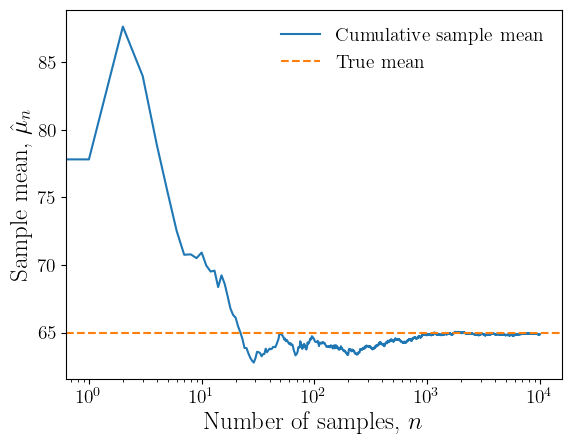

In [11]:
n_max = 10**4  #sample size
nrange = np.arange(1, n_max+1)
W1_samples =  W1.rvs(size=n_max)  #generate samples of waiting times for the 'L'
W2_samples =  W2.rvs(size=n_max)  #generate samples of waiting times for the taxi
print("'L' waiting time W1 samples = ",W1_samples[:20])
print("Taxi waiting time W2 samples = ",W2_samples[:20])
T_samples = 47 + W1_samples + W2_samples  #generate samples of total travel time
sample_mean_T = np.cumsum(T_samples) / nrange  #compute the travel time sample means for first 1, 2, ..., n samples

plt.semilogx(sample_mean_T, label="Cumulative sample mean")
plt.axhline(true_mean_T, color=colors["orange"], linestyle='--', label="True mean")
plt.xlabel(r"Number of samples, $n$")
plt.ylabel(r"Sample mean, $\hat{\mu}_n$")
plt.legend();  #add a semi-colon to suppress output saying that there was a plot

#### Do you notice that
* The sample mean converges to the true (population) mean
* The convergence is not monotonic, but oscillatory
* Each time that you run the cell above the output changes

### What is the convergence rate?

Now let's repeat this experiment $R$ times and look at the average convergence. Notice that the error tends to zero at a rate of $\mathcal{O}(n^{-1/2})$.  For $r =  1, 2, \ldots, R$
\begin{gather}
W_{11}^{(r)}, W^{(r)}_{21}, \ldots \overset{\text{IID}}{\sim} \mathcal{U}[0,20] \\
W_{12}^{(r)}, W_{22}^{(r)}, \ldots \overset{\text{IID}}{\sim} \text{zero inflated exponential} \\
T_{i}^{(r)} = 47 + W_{i1}^{(r)} + W_{i2}^{(r)}. \quad i=1, 2 \ldots 
\end{gather}
and then compute the sample mean
$$
\widehat{\mu}_n^{(r)} = \frac 1n \sum_{i=1}^n T_i^{(r)}, \quad n = 1, 2, \ldots
$$

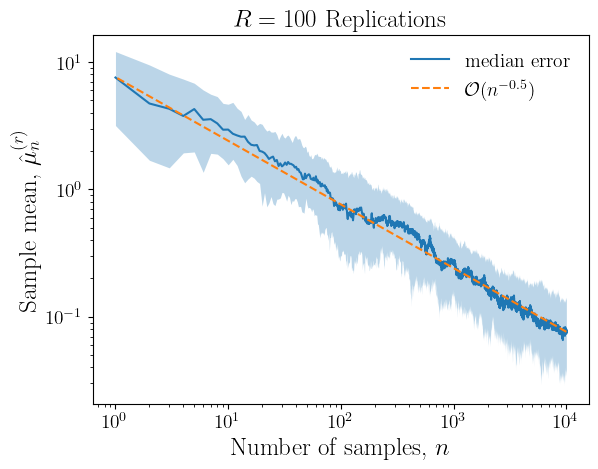

In [17]:
R = 100 #number of replications
W1_R_samples =  W1.rvs(size=(n_max,R))  #generate R replications of samples of waiting times for the 'L'
W2_R_samples =  W2.rvs(size=(n_max,R))  #generate R replications of samples of waiting times for the taxi
T_R_samples = 47 + W1_R_samples + W2_R_samples  #generate N replications of samples of total travel time
sample_mean_T_R_reps = np.cumsum(T_R_samples, axis = 0) / nrange[:, None]   #compute the travel time sample means for all N replications
error_sample_mean_T = np.abs(true_mean_T - sample_mean_T_R_reps)  #errors
bot_per = 25
top_per = 75
err_bot = np.percentile(error_sample_mean_T, bot_per, axis=1)
err_med = np.percentile(error_sample_mean_T, 50, axis=1)
err_top = np.percentile(error_sample_mean_T, top_per, axis=1)
fig, ax = plt.subplots()
ax.loglog(nrange,err_med, '-', color = colors["blue"], label="median error")
ax.fill_between(nrange, err_bot, err_top, color = colors["blue"],alpha = 0.3, linewidth = 0)
init.plot_rate_line(ax, nrange[[-1,0]], y_start=err_med[-1], rate=0.5, color=colors["orange"])
ax.set_xlabel(r"Number of samples, $n$")
ax.set_ylabel(r"Sample mean, $\hat{\mu}^{(r)}_n$")
ax.set_title(f"$R = {R}$ Replications")
plt.legend(frameon=False);